# Single Model Training

This notebook is to enable model training for a single model using the specified parameters in config.yaml.


In [15]:
# Import required libraries
import sys
import os
project_root = os.path.abspath(os.path.join(os.getcwd(), "..", "..", "..", "..",))
sys.path.append(project_root)
from src.pipelines.xgboost.train_single_model import main

## 1. Run Model

In [16]:
from src.core.models.xgboost import XgboostModel
import pandas as pd


model = XgboostModel().load_model(
    '/Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_133929/model_0.pickle'
)


feature_importance = pd.read_csv(f"{model.run_directory}/feature_importance.csv")
features = list(feature_importance["feature"][1:100].values)

INFO:src.core.models.xgboost:Model loaded from /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_133929/model_0.pickle


In [17]:
# Now you can import from core if needed
from src.core.clients.bigquery import BigQueryClient
from src.core.config_loader import ConfigLoader

bq_client = BigQueryClient()
config_loader = ConfigLoader()

sales_query = f"""
    SELECT 
    ctx_item_id,
    ctx_date_month,
    ctx_dept_id,
    ctx_store_id,
    {config_loader.target_col},
    {config_loader.benchmark_col},
    {','.join(features)}
    FROM `porygon-pipelines.walmart_training_tables.walmart_master_table` tgt
    WHERE 
        tgt.ctx_store_id = 'CA_1'
        AND is_stockout_tgt = 0
        AND fea_item_longevity_months >=3
"""


# Extract data
df = bq_client.load_from_query(sales_query)


INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
/Users/anapreciado/Desktop/porygon-demand-forecasting/venv/lib/python3.13/site-packages/google/cloud/bigquery/table.py:1994: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(
INFO:src.core.clients.bigquery:Loaded 103646 rows from custom query.


In [18]:
trained_model = main(features = features)

INFO:src.pipelines.xgboost.train_single_model:
        XGBoost Model Training Pipeline is starting...
        
INFO:src.core.clients.bigquery:BigQuery client initialized for project: porygon-pipelines
INFO:src.core.clients.bigquery:Loaded 110992 rows from table: walmart_master_table
INFO:src.pipelines.xgboost.train_single_model:Filtering outliers ...
INFO:src.pipelines.xgboost.train_single_model:Training model...
INFO:src.core.models.xgboost:
            Training XGBoost Model...
            


[0]	validation_0-quantile:0.29917	validation_1-quantile:0.29118
[1]	validation_0-quantile:0.23287	validation_1-quantile:0.22635
[2]	validation_0-quantile:0.19118	validation_1-quantile:0.18606
[3]	validation_0-quantile:0.16474	validation_1-quantile:0.16066
[4]	validation_0-quantile:0.14852	validation_1-quantile:0.14583
[5]	validation_0-quantile:0.13899	validation_1-quantile:0.13712
[6]	validation_0-quantile:0.13329	validation_1-quantile:0.13282
[7]	validation_0-quantile:0.12986	validation_1-quantile:0.13036
[8]	validation_0-quantile:0.12770	validation_1-quantile:0.12882
[9]	validation_0-quantile:0.12623	validation_1-quantile:0.12803
[10]	validation_0-quantile:0.12519	validation_1-quantile:0.12743
[11]	validation_0-quantile:0.12444	validation_1-quantile:0.12702
[12]	validation_0-quantile:0.12372	validation_1-quantile:0.12672
[13]	validation_0-quantile:0.12302	validation_1-quantile:0.12650
[14]	validation_0-quantile:0.12251	validation_1-quantile:0.12652
[15]	validation_0-quantile:0.12197	

INFO:src.core.models.xgboost:Model saved to /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_145411/model_0.pickle
INFO:src.core.models.xgboost:
            Model Training Pipeline completed successfully!
            Run ID: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_145411
            Artifacts saved to: /Users/anapreciado/Desktop/porygon-demand-forecasting/src/artifacts/models/xgboost/20260127_145411
            


## 2. Compare metrics with Benchmark

1. Compare Metrics (MdAPE, MdAE) with benchmark in total and accross validation sets of interest

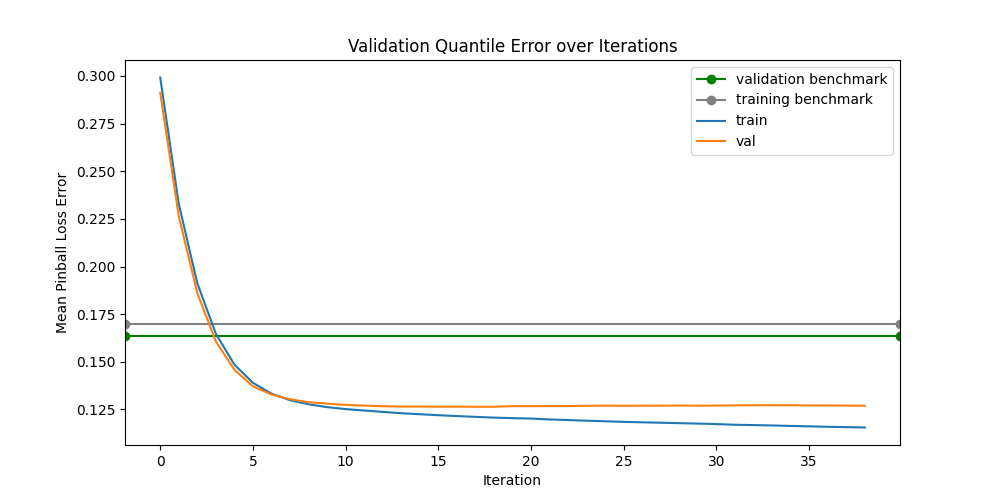

In [19]:
from IPython.display import Image, display
display(Image(trained_model.plot_bias_variance_tradeoff_path))

## 6. Evaluate Residuals

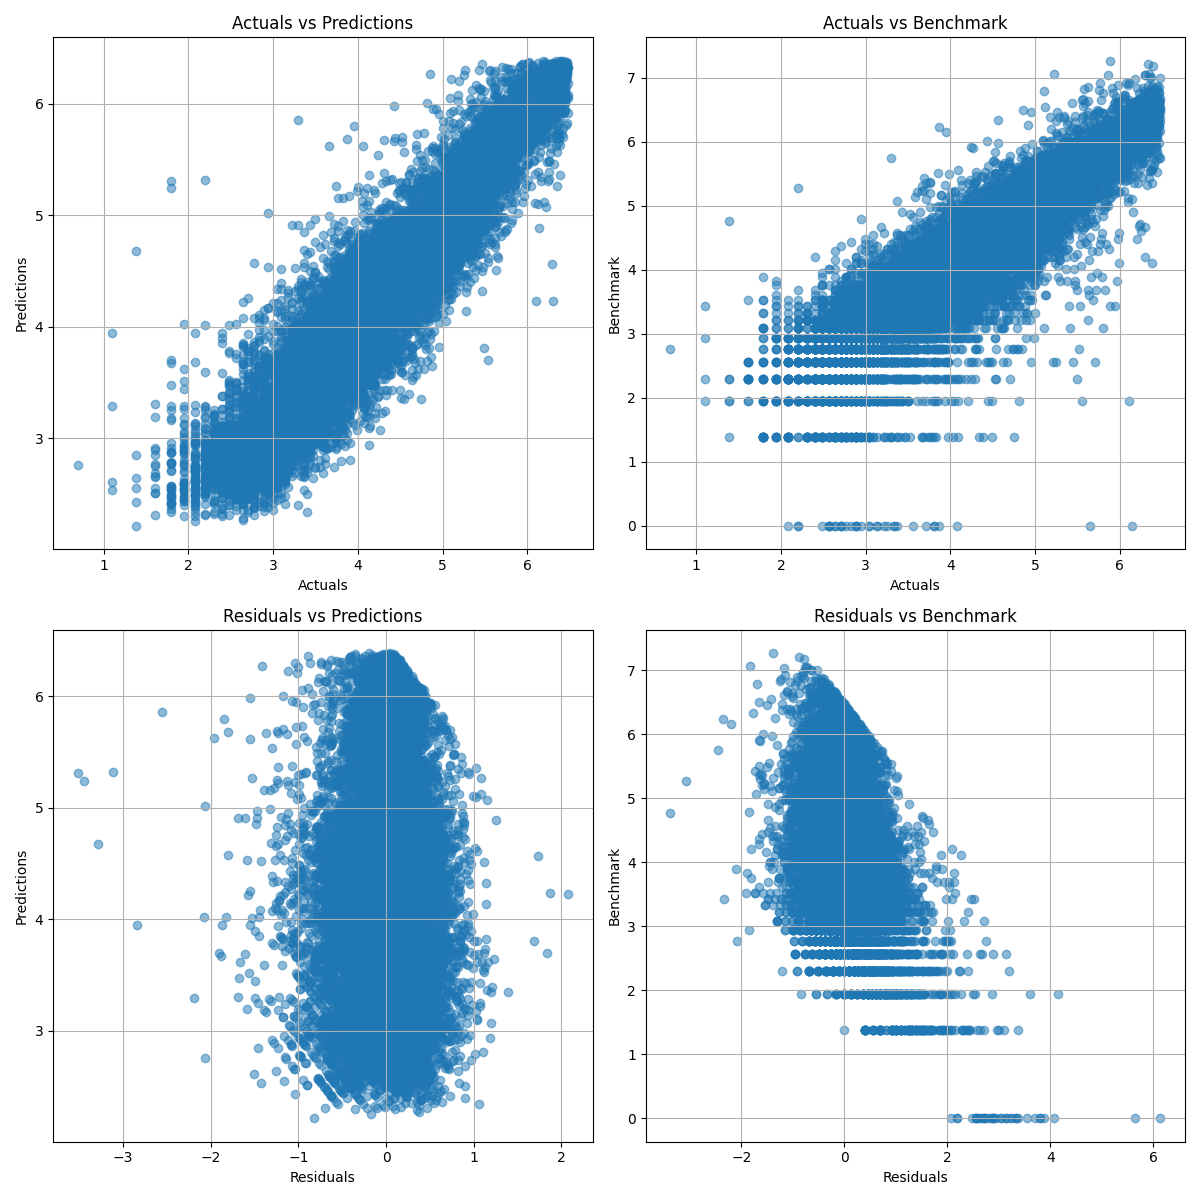

In [20]:
from IPython.display import Image, display
display(Image(trained_model.plot_residuals_paths))

## 8. Feature Importance

In [21]:
trained_model.feature_importance.head(20)

,feature,importance
1,fea_item_monthly_sales_roll_std_12_months,73.0
0,feature_avg_sales_not_snap_ca,59.0
95,fea_item_monthly_sales_roll_avg_6_months,56.0
28,fea_item_monthly_sales_lag_10_months,46.0
75,fea_item_monthly_sales_lag_9_months,43.0
9,fea_item_max_days_since_last_sale,41.0
3,fea_item_monthly_sales_roll_coeffvar_12_months,37.0
65,fea_sum_dept_num_days_item_is_zero_sales,35.0
47,fea_sum_cat_monthly_sales_roll_std_12_months,35.0
2,fea_item_monthly_sales_ratio_lag_2_months,34.0


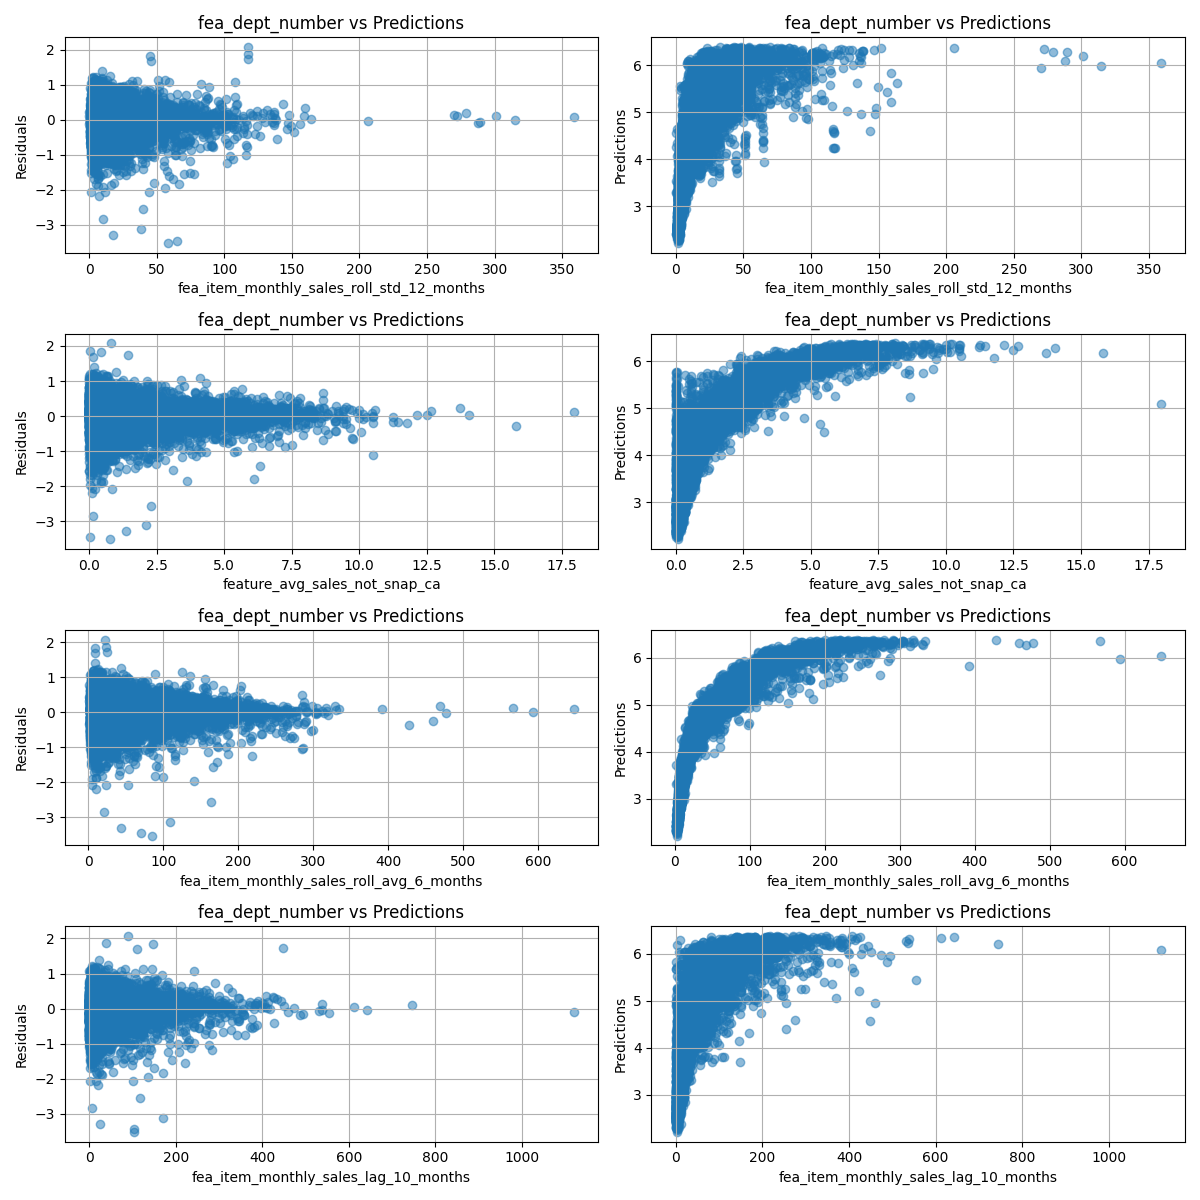

In [22]:
from IPython.display import Image, display
display(Image(trained_model._plot_importance_path))